In [12]:
import jax.numpy as np
from jax import grad, jit, vmap
from jax import random
import matplotlib.pyplot as plt

from svgd import svgd, update, phi_j_batched, phi_j, kernel_param_update_rule
from utils import ard

# multidim SVGD concentrates around max a posteriori

## test ard

In [18]:
n = 10
d = 2

# generate data
key = random.PRNGKey(3)
x = random.normal(key, (n,d)) - 10

In [19]:
x.shape

(10, 2)

In [22]:
ard(x[0], x[0], 1)

DeviceArray(1., dtype=float32)

## here's the problem:

In [23]:
from jax.scipy.stats import norm
from svgd import kernel_param_update_rule

@jit
def logp(x):
    """
    Parameters: 
    * x: np array of shape (d,)
    
    Returns: 
    * scalar log(p(x)), where p(x) is multidim gaussian
    """
    assert x.ndim == 1
    return np.sum(norm.logpdf(x, loc=0, scale=1))

In [36]:
n = 10
d = 2
stepsize = 0.01
L = int(10 / stepsize)

# generate data
key = random.PRNGKey(0)
x0 = random.normal(key, (n,d)) - 10

x=x0
# kernel_param=kernel_param_update_rule(x)
kernel_param=2
kernel_param_update_rule = None

In [37]:
log = {
    "kernel_params": [],
    "particle_mean": [np.mean(x, axis=0)],
    "particle_var": [np.var(x, axis=0)]
}

for i in range(L):
    x = update(x, logp, stepsize, kernel_param)
    
    # update
    kernel = lambda x, y: ard(x, y, kernel_param)

    xnew = []
    n = x.shape[0]
    for i, xi in enumerate(x):
        repeated = np.tile(xi, (n, 1))
        xnew.append(stepsize * np.sum(phi_j_batched(x, repeated, logp, kernel), axis = 0))
    xnew = np.array(xnew)
    xnew += x
    #####
    x = xnew
    
    log["particle_mean"].append(np.mean(x, axis=0))
    log["particle_var"].append(np.var(x, axis=0))

In [38]:
xout=x

log["particle_mean"] = np.array(log["particle_mean"])
log["particle_var"] = np.array(log["particle_var"])
log["kernel_params"] = np.array(log["kernel_params"])

print("vars:")
print('x: ', np.var(xout, axis=0))
print('x0:', np.var(x0, axis=0))
print()
print("means:")
print('x: ', np.mean(xout, axis=0))
print('x0:', np.mean(x0, axis=0) + 10)

vars:
x:  [0.93684864 0.90393126]
x0: [1.5073496 1.1993192]

means:
x:  [-0.00160565  0.00146102]
x0: [0.3955822  0.07276726]


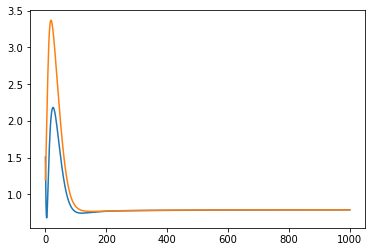

In [33]:
_ = plt.plot(log["particle_var"])

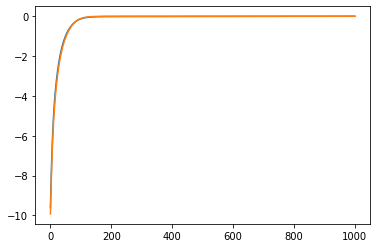

In [35]:
_ = plt.plot(log["particle_mean"])

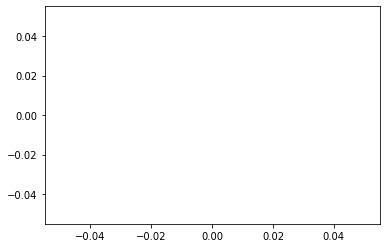

In [34]:
_ = plt.plot(log["kernel_params"])

## generate data

In [ ]:
n = 100
d = 2
key = random.PRNGKey(0)
x0 = random.normal(key, shape=(n, d)) - 10

stepsize = 0.001
L = int(1 / stepsize)

In [ ]:
from jax.scipy.stats import norm

@jit
def logp(x):
    """
    Parameters: 
    * x: np array of shape (d,)
    
    Returns: 
    * scalar log(p(x)), where p(x) is multidim gaussian
    """
    assert x.ndim == 1
    out = np.sum(norm.logpdf(x, loc=0, scale=1))
    return np.squeeze(out) # to be able to take a gradient, output must be scalar

In [ ]:
xout, log = svgd(x0, logp, stepsize, L, kernel_param=None, kernel_param_update_rule=vkernel_param_update_rule)
if "errors" in log.keys():
    print(log["errors"])

In [ ]:
np.var(xout, axis=0)

In [ ]:
np.mean(xout, axis=0)

In [ ]:
len(log["particle_mean"])

In [ ]:
plt.plot(log["particle_mean"])

# testing
where does the NaN come from?

In [ ]:
from utils import ard

In [ ]:
x0.shape

In [ ]:
# x = x0[:, 0]
# x = np.reshape(x, newshape=(n, 1))
x = x0
print(x.shape)
kernel_param = kernel_param_update_rule(x)

In [ ]:
xj = x[0]
xi = x[1]

In [ ]:
xj

In [ ]:
norm.logpdf(xj, loc=0, scale=1)

In [ ]:
logp(xj)

In [ ]:
grad(logp)(xj)

In [ ]:
kernel(xj, xi)

In [ ]:
grad(kernel)(xj, xi)

In [ ]:
kernel_params = []

In [ ]:
# update kernel:
kernel_param = vkernel_param_update_rule(x)
kernel_params.append(kernel_param)
kernel = lambda x, y: ard(x, y, kernel_param)

# update x:
xnew = []
n = x.shape[0]
for i, xi in enumerate(x):
    repeated = np.tile(xi, (n, 1))
    xnew.append(stepsize * np.sum(phi_j_batched(x, repeated, logp, kernel), axis = 0))
xnew = np.array(xnew)
xnew += x
x = xnew

np.mean(x, axis=0)